In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import proportional_hazard_test
from lifelines.plotting import add_at_risk_counts

In [2]:
print_plots = False

if print_plots:
    output_path = '~/output'
    import os
    os.makedirs(output_path, exist_ok=True)

***
# Load Stanford Data
Exported from R

In [3]:
dfp = pd.read_csv('~/stanford.csv')

In [4]:
dfp.head(5)

,id,time,status,age,t5,agecat
0,21,0.5,1,41,0.87,Over 40
1,133,1.0,1,21,0.47,Under 40
2,16,1.0,1,54,0.47,Over 40
3,2,3.0,1,40,1.66,Over 40
4,90,7.0,1,28,1.00,Under 40


***
# [Kaplan-Meier Model](https://lifelines.readthedocs.io/en/latest/Quickstart.html#kaplan-meier-nelson-aalen-and-parametric-models)

In [5]:
def km_plot_by_factor(factor, dfp, err=True, tablim=2):
    kmf= []
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    for i,v in enumerate(sorted(dfp[factor].unique())[::-1]):
        # Create a fitter
        kmf.append(KaplanMeierFitter())
        kmf[i].fit(dfp.query(f'agecat == "{v}"')['time'], event_observed=dfp.query(f'agecat == "{v}"')['status'], label=v)        
        if err:
            kmf[i].plot(ax=ax)
        else:
            kmf[i].survival_function_.plot(ax=ax)

    add_at_risk_counts(*kmf[:tablim])
    stat_test = multivariate_logrank_test(dfp['time'], dfp[factor], dfp['status'])
    ax.set_title(f'Logrank Test p-value: {stat_test.p_value:.4g}')
    ax.set_ylabel('Survival')
    ax.set_xlabel('Time')
    fig.tight_layout()
    if print_plots:
        fig.savefig(f'{output_path}/km_by_{factor}.pdf')

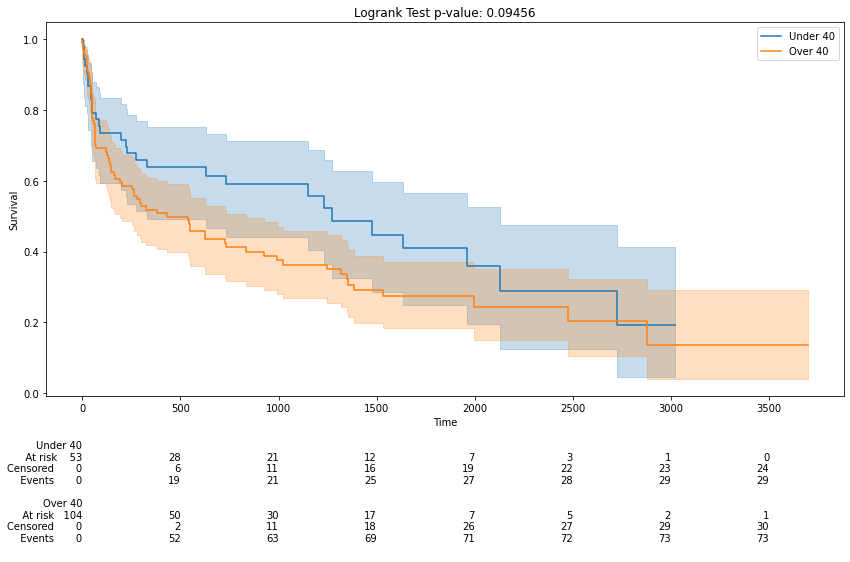

In [6]:
km_plot_by_factor('agecat', dfp)

***
# [Cox Model](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#fitting-the-regression)

## Fit Model

In [7]:
covariates = ['age']

cph = CoxPHFitter()
cph.fit(dfp[['time', 'status']+covariates], duration_col='time', event_col='status')

<lifelines.CoxPHFitter: fitted with 157 total observations, 55 right-censored observations>

In [8]:
cph.print_summary(model='Cox Age', decimals=4)

<lifelines.CoxPHFitter: fitted with 157 total observations, 55 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 157
number of events observed = 102
   partial log-likelihood = -447.2857
         time fit was run = 2021-02-17 19:52:59 UTC
                    model = Cox Age

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age       0.0299     1.0304     0.0114           0.0076           0.0522               1.0077               1.0535

               z      p   -log2(p)
covariate                         
age       2.6329 0.0085     6.8840
---
Concordance = 0.5955
Partial AIC = 896.5714
log-likelihood ratio test = 7.6173 on 1 df
-log2(p) of ll-ratio test = 7.4344

In [9]:
cph.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           7.62 0.01      7.43

## [Plot the hazard ratios](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#plotting-the-coefficients)

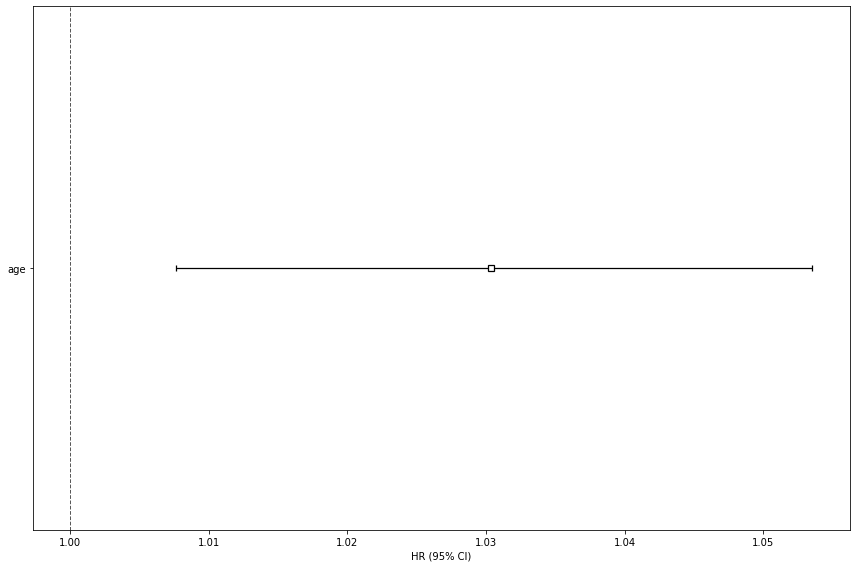

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = cph.plot(hazard_ratios=True)
fig.tight_layout()
if print_plots:
    fig.savefig(f'{output_path}/cox_hrs.pdf')

## [Plot the effect of varying a covariate](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#plotting-the-effect-of-varying-a-covariate)
[Note that the mean age is being used as the baseline value](https://github.com/CamDavidsonPilon/lifelines/issues/543).

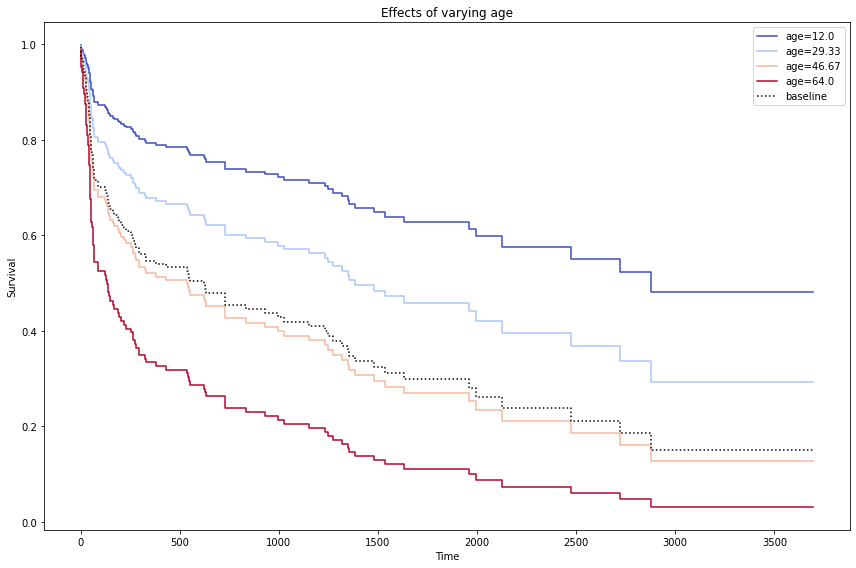

In [11]:
for covariate in covariates:
    values = sorted(list(dfp[covariate].unique()))
    if len(values) > 3:
        values = np.around(np.linspace(dfp[covariate].min(), dfp[covariate].max(), 4), 2)
    ax = cph.plot_partial_effects_on_outcome(covariates=covariate, values=values, cmap='coolwarm')
    ax.set_title(f'Effects of varying {covariate}')
    ax.set_ylabel('Survival')
    ax.set_xlabel('Time')
    fig = ax.figure
    fig.set_figwidth(12)
    fig.set_figheight(8)
    fig.tight_layout()
    if print_plots:
        fig.savefig(f'{output_path}/cox_survival_varying_{covariate}.pdf')

## Check Assumptions and Fit

### [Test the proportional hazard assumptions](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html)
Would produce Schoenfeld residual plots if needed

In [12]:
cph.check_assumptions(dfp[['time', 'status']+covariates], p_value_threshold=0.01, show_plots=True)

Proportional hazard assumption looks okay.


[]

In [13]:
proportional_hazard_test(cph, dfp[['time', 'status']+covariates], time_transform='rank')

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 157 total observations, 55 right-censored observations>
         test_name = proportional_hazard_test

---
     test_statistic    p  -log2(p)
age            1.07 0.30      1.73

### [Create Linear Predictors for Residual Plots](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html#lifelines.fitters.coxph_fitter.SemiParametricPHFitter.predict_log_partial_hazard)
And setup plotting

In [14]:
dfp_linear_predictors = cph.predict_log_partial_hazard(dfp[covariates])

In [15]:
def plot_residuals(dfp, residual_type, x_axis='time', x_axis_label='Time', y_axis_label_suffix=' Residuals'):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()

    for status in [True, False]:
        if status:
            label = 'Event'
            c = 'tab:blue'
        else:
            label = 'Censored'
            c = 'tab:orange'

        ax.scatter(dfp.query(f'status == {status}')[x_axis], dfp.query(f'status == {status}')[residual_type], label=label, s=50, c=c)

    ax.set_ylabel(f'{residual_type.title()}{y_axis_label_suffix}')
    ax.set_xlabel(x_axis_label)
    ax.legend()

    fig.tight_layout()
    if print_plots:
        fig.savefig(f'{output_path}/cox_{residual_type}_residuals_vs_{x_axis}.pdf')

In [16]:
dfp_residuals = dfp[['time', 'status']+covariates].copy()
dfp_residuals['Observation'] = dfp_residuals.index
dfp_residuals['linear_predictors'] = dfp_linear_predictors
dfp_residuals['scaled_schoenfeld'] = cph.compute_residuals(dfp[['time', 'status']+covariates], 'scaled_schoenfeld')
dfp_residuals['martingale'] = cph.compute_residuals(dfp[['time', 'status']+covariates], 'martingale')['martingale']
dfp_residuals['deviance'] = cph.compute_residuals(dfp[['time', 'status']+covariates], 'deviance')['deviance']
for covariate in covariates:
    dfp_residuals[f'dfbeta_{covariate}'] = cph.compute_residuals(dfp[['time', 'status']+covariates], 'delta_beta')[covariate]

### Scaled Schoenfeld

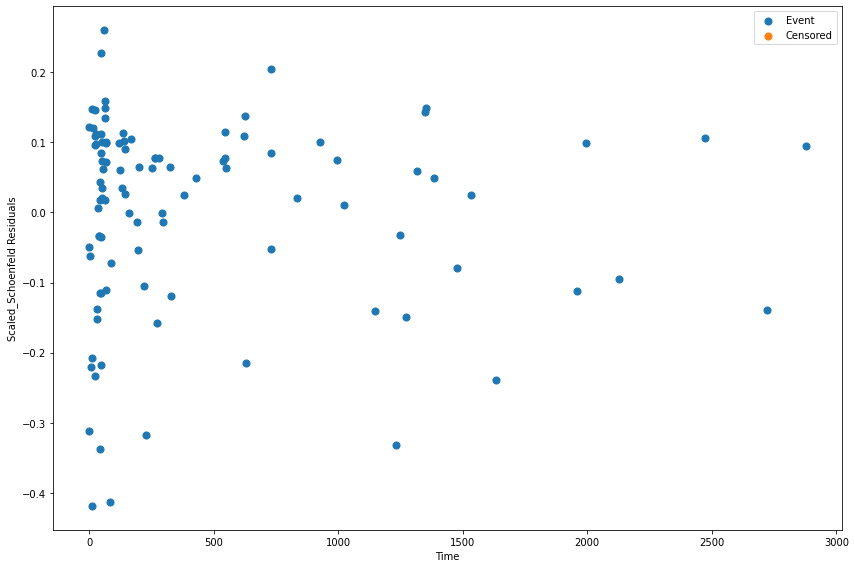

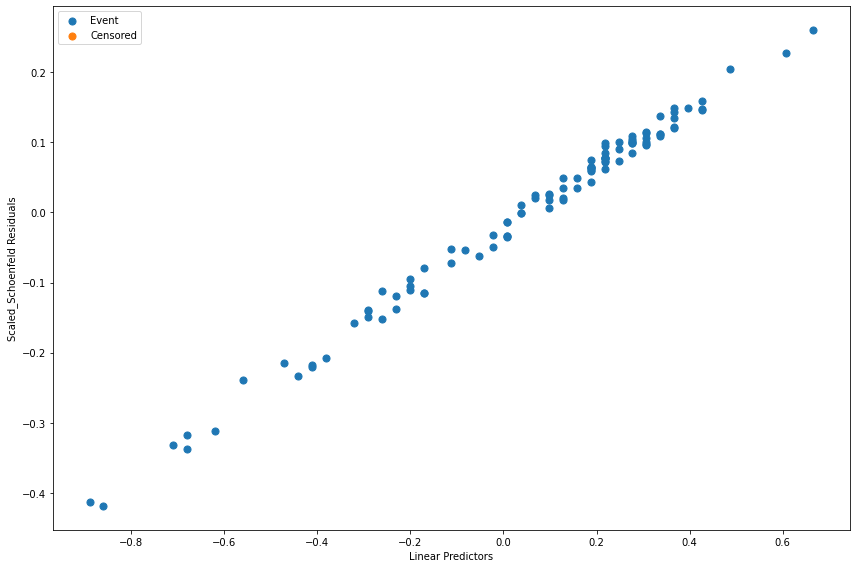

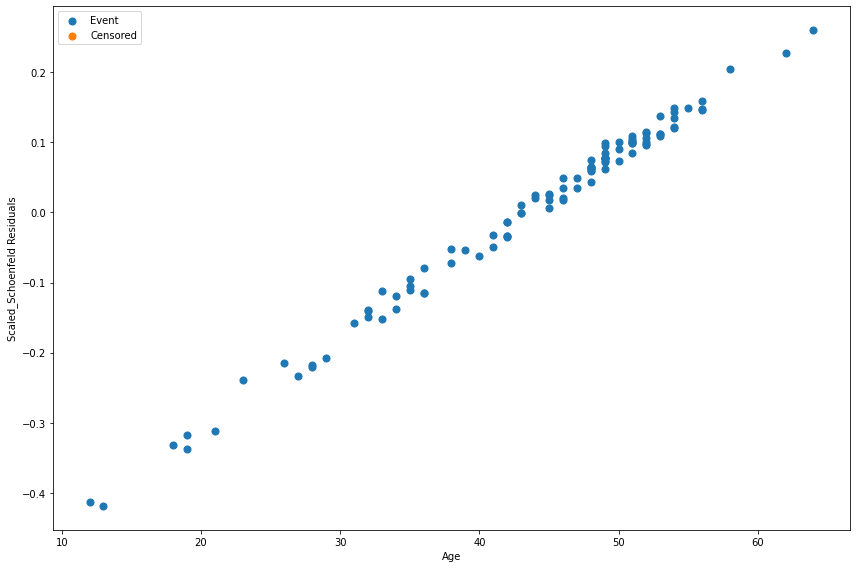

In [17]:
plot_residuals(dfp_residuals, 'scaled_schoenfeld')
plot_residuals(dfp_residuals, 'scaled_schoenfeld', x_axis='linear_predictors', x_axis_label='Linear Predictors')
for covariate in covariates:
    plot_residuals(dfp_residuals.dropna(), 'scaled_schoenfeld', x_axis=covariate, x_axis_label=covariate.title())

### [Martingale Residuals](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html#Martingale-residuals)

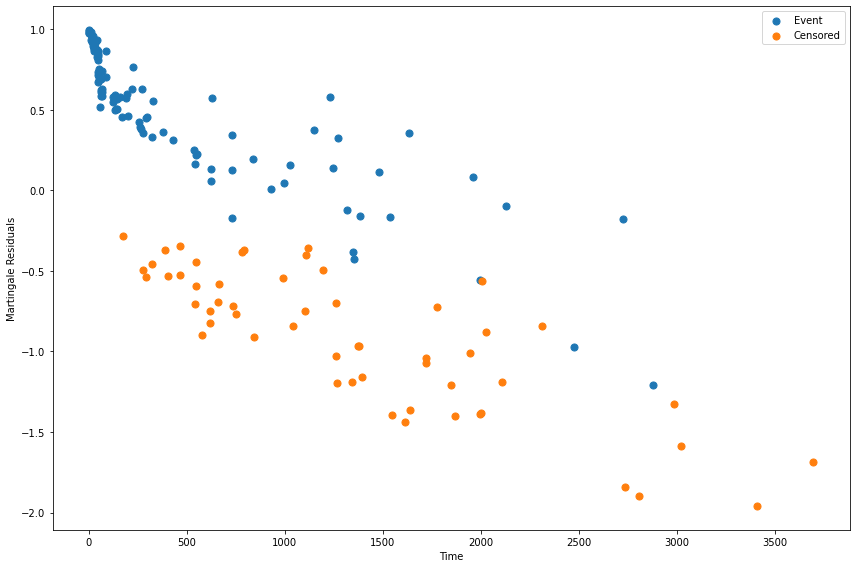

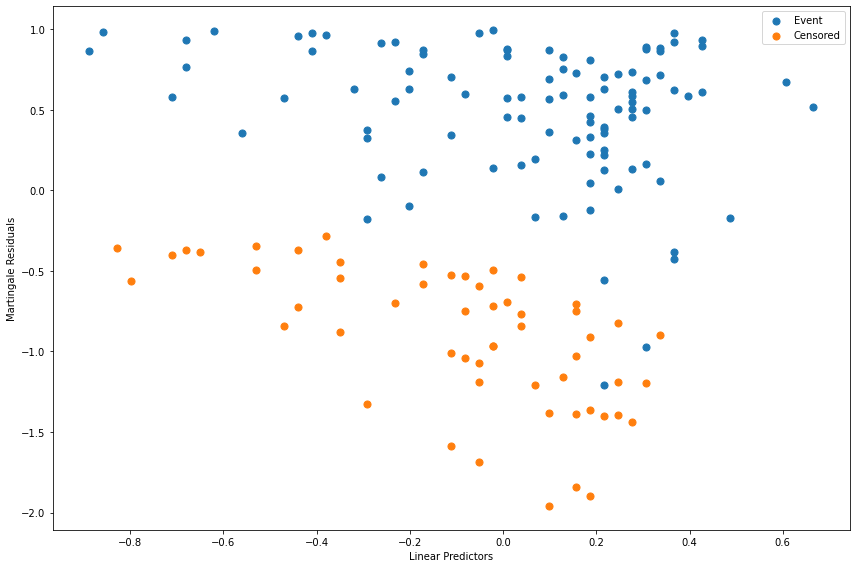

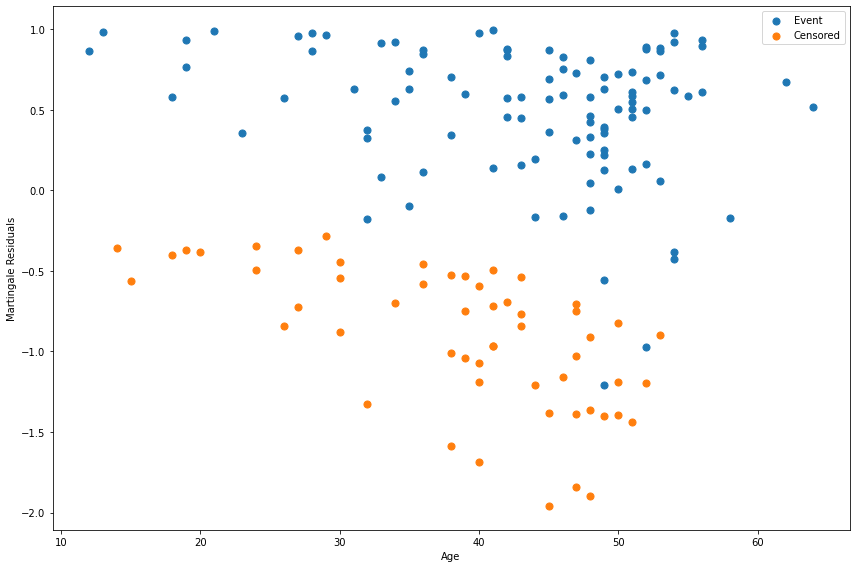

In [18]:
plot_residuals(dfp_residuals, 'martingale')
plot_residuals(dfp_residuals, 'martingale', x_axis='linear_predictors', x_axis_label='Linear Predictors')
for covariate in covariates:
    plot_residuals(dfp_residuals, 'martingale', x_axis=covariate, x_axis_label=covariate.title())

### [Deviance Residuals](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html#Deviance-residuals)

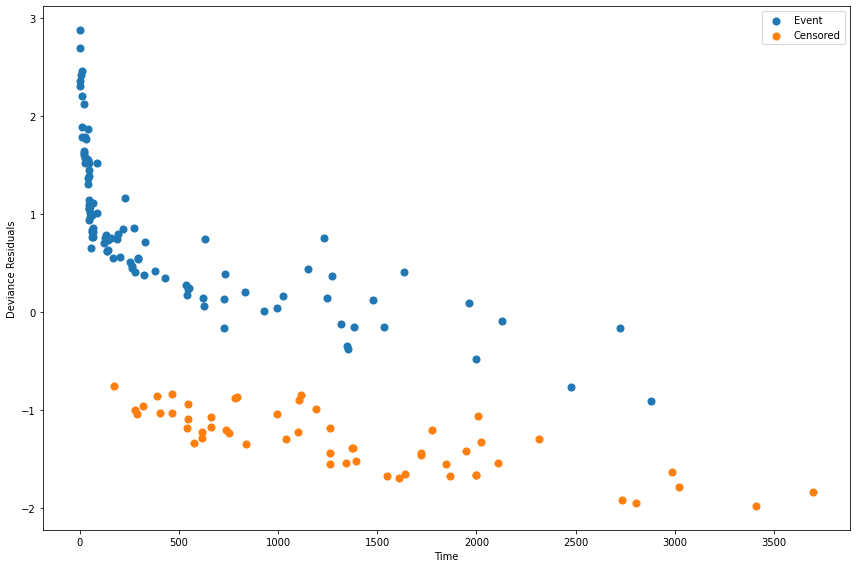

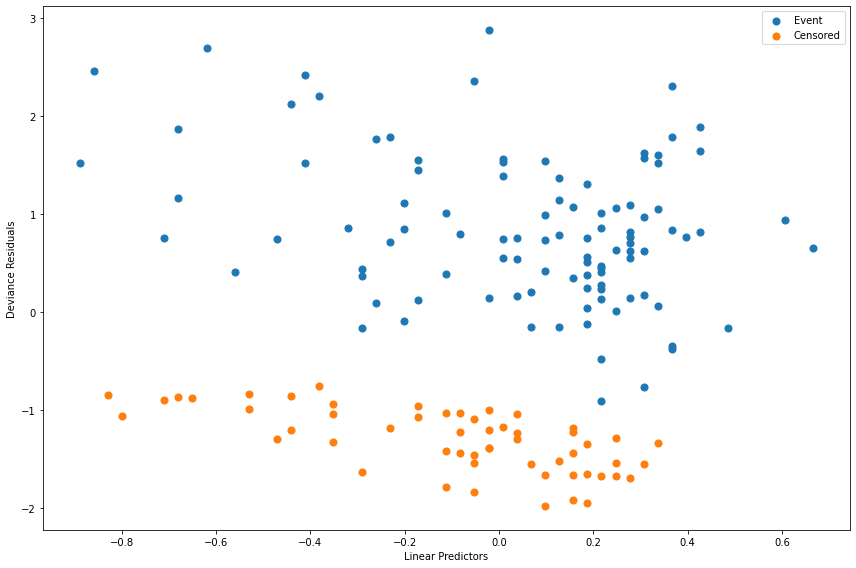

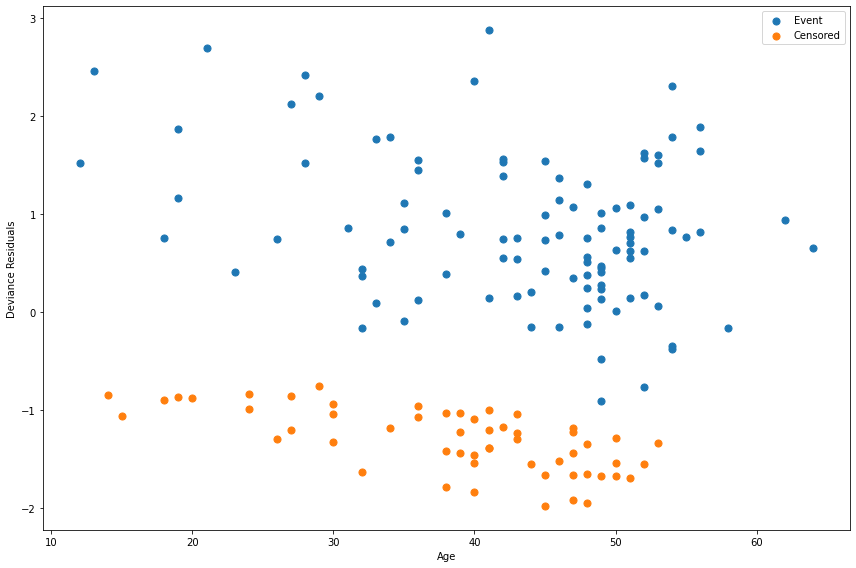

In [19]:
plot_residuals(dfp_residuals, 'deviance')
plot_residuals(dfp_residuals, 'deviance', x_axis='linear_predictors', x_axis_label='Linear Predictors')
for covariate in covariates:
    plot_residuals(dfp_residuals, 'deviance', x_axis=covariate, x_axis_label=covariate.title())

### dfbeta

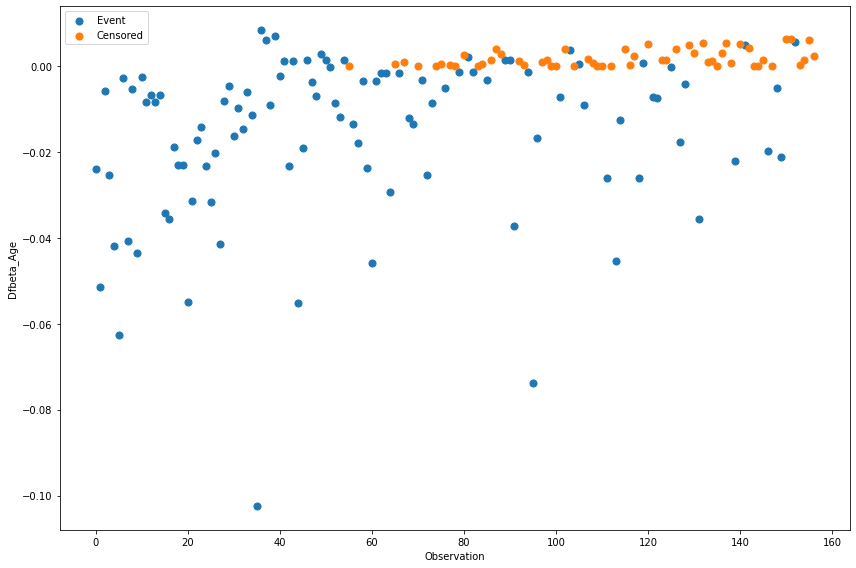

In [20]:
for covariate in covariates:
    plot_residuals(dfp_residuals, f'dfbeta_{covariate}', x_axis='Observation', x_axis_label='Observation', y_axis_label_suffix='')

***
### You may want to also look into these additional lifelines abilities:
* [Sample size determination](https://lifelines.readthedocs.io/en/latest/Examples.html#sample-size-determination-under-a-coxph-model)
* [Model probability calibration](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-probability-calibration)
* [Cross validation](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cross-validation)